In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Object detection for identifying tables


(Object detection algorithm [Yolo V1 and Pretrain FasterRCNN with ResNet50])

This notebook provides a walkthrough of object detection using FasterRCNN with resnet50 as backbone and yolo v1 from scratch. It includes exploration about dataset and various deep learning based object detection algorithm using Pytorch.

### Content
1. **Dataset preparation**
2. **Exploratory Analysis**
3. **Object detection algorithms**
    * Pretrained FasterRCNN using ResNet50 backbone
    * Yolo V1

### 1. Dataset preparation
Load necessary libraries and dataset. Perform transformation on dataset for it to be consumed by algorithms.

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw
from tqdm import tqdm
from collections import Counter

import torch
import torchvision
import torch.nn as nn
import torch.utils.data
import utils
import transforms as T
import torchvision.transforms.functional as FT
from torchvision import transforms
from torch import optim
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate

%matplotlib inline

Loading dataset into dataframe and displaying top training and testing records

In [3]:
TRN_DATA_PATH = "data/train.csv"
TEST_DATA_PATH = "data/val.csv"

In [4]:
df_trn = pd.read_csv(TRN_DATA_PATH)
df_trn.head()

,image_id,xmin,ymin,xmax,ymax,label
0,0101_003.png,770,946,2070,2973,table
1,0110_099.png,270,1653,2280,2580,table
2,0113_013.png,303,343,2273,2953,table
3,0140_007.png,664,1782,1814,2076,table
4,0146_281.png,704,432,1744,1552,table


In [5]:
df_test = pd.read_csv(TEST_DATA_PATH)
df_test.head()

,image_id,xmin,ymin,xmax,ymax,label
0,9533_039.png,60,396,1113,2420,table
1,9533_039.png,1143,1126,2240,2230,table
2,9534_001.png,196,378,2146,956,table
3,9534_001.png,184,1028,2160,1636,table
4,9534_028.png,642,1388,1944,1981,table


In [6]:
print(f"Number of training images/non unique records are {len(df_trn)}")
print(f"Number of training images/unique records are {len(df_trn.image_id.unique())}")
print(f"Number of training images in train_images folder are {len(os.listdir('data/train_images/'))}")

Number of training images/non unique records are 418
Number of training images/unique records are 338
Number of training images in train_images folder are 335


In [7]:
print(f"Number of testing images/non unique records are {len(df_test)}")
print(f"Number of testing images/unique records are {len(df_test.image_id.unique())}")
print(f"Number of testing images in test_images folder are {len(os.listdir('data/test_images/'))}")

Number of testing images/non unique records are 100
Number of testing images/unique records are 65
Number of testing images in test_images folder are 68


### 2. Exploratory Analysis
Above observations show there are records but no related images present inside training folder and testing folder contains extra images.
So let's delete them for now from dataframe

In [8]:
# Delete non present image records from dataframe
def delete_row(df, img_type="train"):
    for record in df.iterrows():
        if not os.path.isfile(f"data/{img_type}_images/{record[1].image_id}"):
            df = df.drop(record[0])
            
    return df.reset_index(drop=True)

In [9]:
df_trn = delete_row(df_trn)
print(f"Number of training images/non unique records are {len(df_trn)}")
print(f"Number of training images/unique records are {len(df_trn.image_id.unique())}")
print(f"Number of training images in train_images folder are {len(os.listdir('data/train_images/'))}")

Number of training images/non unique records are 413
Number of training images/unique records are 335
Number of training images in train_images folder are 335


In [10]:
df_test = delete_row(df_test, "test")
print(f"Number of testing images/non unique records are {len(df_test)}")
print(f"Number of testing images/unique records are {len(df_test.image_id.unique())}")
print(f"Number of testing images in test_images folder are {len(os.listdir('data/test_images/'))}")

Number of testing images/non unique records are 100
Number of testing images/unique records are 65
Number of testing images in test_images folder are 68


Convert bounding box size according to resize shape of the image

In [11]:
# Normalise data for yolo v1 implementation
def norm_box(width, height, xmin, xmax, ymin, ymax):
    x = (xmin + xmax)/2. * 1./width
    w = (xmax - xmin) * 1./width
    y = (ymin + ymax)/2. * 1./height
    h = (ymax - ymin) * 1./height
    
    return (x, y, w, h)

In [12]:
# Convert bounding box to according to resize version of the image
def convert_boundingbox(img_size, bounding_box):
    img_height, img_width = img_size
    xmin, ymin, xmax, ymax = bounding_box

    width = xmax - xmin
    height = ymax - ymin

    conv_x = (448. / img_width)
    conv_y = (448. / img_height)
    width = int(width * conv_x)
    height = int(height * conv_y)
    xmin = int(max(xmin * conv_x, 0))
    ymin = int(max(ymin * conv_y, 0))
    xmax = xmin + width
    ymax = ymin + height
    
    return xmin, ymin, xmax, ymax

In [13]:
# Apply transformation on all images of bounding box
def convert_all(df, img_type="train"):
    df_records = []
    for record in df.iterrows():
        img = cv2.imread(f"data/{img_type}_images/{record[1].image_id}")
        try:
            img_height, img_width, img_channel = img.shape
        except Exception as e:
            print(e)
        xmin = record[1].xmin
        ymin = record[1].ymin
        xmax = record[1].xmax
        ymax = record[1].ymax

        xmin, ymin, xmax, ymax = convert_boundingbox((img_height, img_width), (xmin, ymin, xmax, ymax))
        
        norm_x, norm_y, norm_width, norm_height = norm_box(img_width, img_height, xmin, xmax, ymin, ymax)
        
        df_records.append((xmin, ymin, xmax, ymax, norm_x, norm_y, norm_width, norm_height))
        
    return df_records

Apply transformation and add back into original dataframe

In [14]:
df_trn[["conv_xmin", "conv_ymin", "conv_xmax", "conv_ymax", "norm_x", "norm_y", "norm_width", "norm_height"]] = convert_all(df_trn)
df_trn.head()

,image_id,xmin,ymin,xmax,ymax,label,conv_xmin,conv_ymin,conv_xmax,conv_ymax,norm_x,norm_y,norm_width,norm_height
0,0101_003.png,770,946,2070,2973,table,135,128,363,403,0.097877,0.080455,0.089623,0.083333
1,0110_099.png,270,1653,2280,2580,table,47,224,400,349,0.087854,0.086818,0.138758,0.037879
2,0113_013.png,303,343,2273,2953,table,53,46,399,400,0.088836,0.067576,0.136006,0.107273
3,0140_007.png,664,1782,1814,2076,table,116,241,317,280,0.084570,0.078939,0.078516,0.011818
4,0146_281.png,704,432,1744,1552,table,123,58,306,210,0.084316,0.040606,0.071934,0.046061


In [15]:
df_test[["conv_xmin", "conv_ymin", "conv_xmax", "conv_ymax", "norm_x", "norm_y", "norm_width", "norm_height"]] = convert_all(df_test, "test")
df_test.head()

,image_id,xmin,ymin,xmax,ymax,label,conv_xmin,conv_ymin,conv_xmax,conv_ymax,norm_x,norm_y,norm_width,norm_height
0,9533_039.png,60,396,1113,2420,table,10,53,194,327,0.039969,0.057576,0.072100,0.083030
1,9533_039.png,1143,1126,2240,2230,table,200,152,392,301,0.115987,0.068636,0.075235,0.045152
2,9534_001.png,196,378,2146,956,table,34,51,376,129,0.080329,0.027273,0.134013,0.023636
3,9534_001.png,184,1028,2160,1636,table,32,139,378,221,0.080329,0.054545,0.135580,0.024848
4,9534_028.png,642,1388,1944,1981,table,112,188,340,268,0.088558,0.069091,0.089342,0.024242


Draw bounding box on batch on images after resizing to check proper data has been generated or not

In [16]:
# Display batch of images
def display_batch(df, batch_size=4, img_type="train"):
    permutation = np.random.permutation(len(df))[:batch_size]
    
    fig, axs = plt.subplots(1, batch_size, figsize=(25, 70))
    for ax, record in zip(axs, df.iloc[permutation].iterrows()):
        img = cv2.imread(f"data/{img_type}_images/{record[1].image_id}")
        img = cv2.resize(img, (448, 448))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        xmin = record[1].conv_xmin
        ymin = record[1].conv_ymin
        xmax = record[1].conv_xmax
        ymax = record[1].conv_ymax
        
        img = cv2.circle(img, (xmin, ymin), 3, (255, 255, 0), 20)
        img = cv2.circle(img, (xmax, ymax), 3, (255, 255, 0), 20)

        img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

        ax.imshow(img)
        ax.grid(True)

    plt.show()

Training images batch

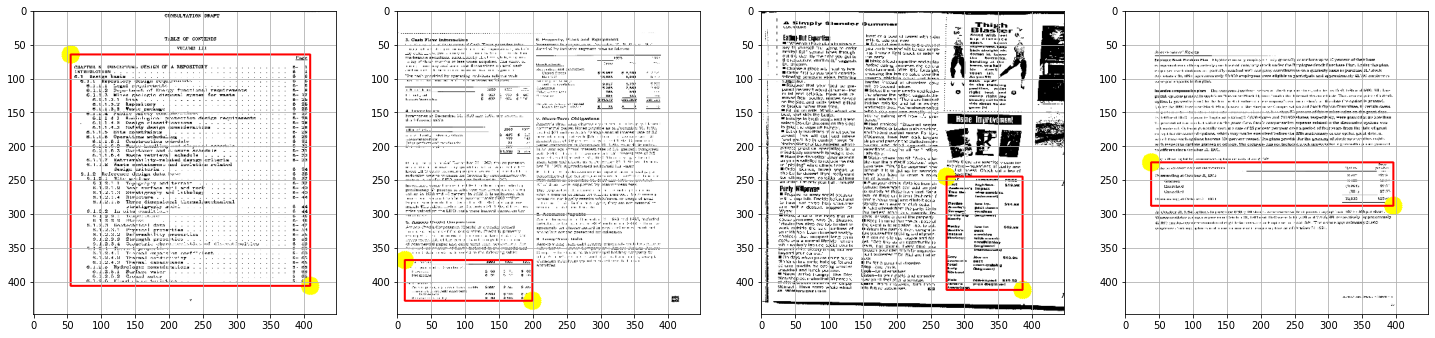

In [17]:
display_batch(df_trn, batch_size=4)

Testing images batch

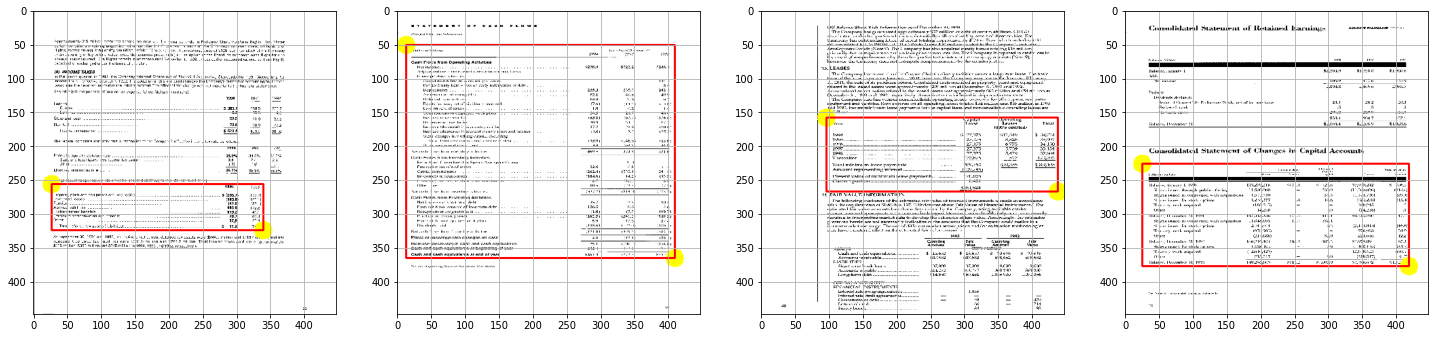

In [18]:
display_batch(df_test, batch_size=4, img_type="test")

## 3. Object detection algorithms

### Implementation of Pretrained Faster RCNN with ResNet backbone

Fetch image from bounding box from dataframe

In [19]:
def parse_one_annot(df, filename):
    boxes_array = df[df["image_id"] == filename][["xmin", "ymin", "xmax", "ymax"]].values

    return boxes_array

Convert fetch image into pytorch tensor

In [20]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())

    return T.Compose(transforms)

Dataset loading class...

In [21]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, root, dataframe, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(root))
        self.df = dataframe
        
    def __getitem__(self, idx):
        # load images and bounding boxes
        img_path = os.path.join(self.root, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        box_list = parse_one_annot(self.df, self.imgs[idx])
        boxes = torch.as_tensor(box_list, dtype=torch.float32)
        
        num_objs = len(box_list)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return img, target
    
    def __len__(self):
         return len(self.imgs)

Let's check single image output of training images

In [22]:
dataset = Dataset(root="data/train_images/", dataframe=df_trn)
dataset.__getitem__(0)

(<PIL.Image.Image image mode=RGB size=2544x3300 at 0x1B5F6F3C070>,
 {'boxes': tensor([[ 770.,  946., 2070., 2973.]]),
  'labels': tensor([1]),
  'image_id': tensor([0]),
  'area': tensor([2635100.]),
  'iscrowd': tensor([0])})

Download and load fasterrcnn resnet50 model for transfer learning

In [23]:
def get_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new on
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [24]:
# use our dataset and defined transformations
dataset = Dataset(root="data/train_images/", dataframe=df_trn, transforms = get_transform(train=True))
dataset_test = Dataset(root="data/test_images/", dataframe=df_test, transforms = get_transform(train=False))

In [25]:
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=utils.collate_fn)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=2, shuffle=False, num_workers=0, collate_fn=utils.collate_fn)
print("We have: {} examples, {} are training and {} testing".format(len(indices), len(dataset), len(dataset_test)))

We have: 335 examples, 295 are training and 40 testing


In [26]:
# Check cuda is available or not
torch.cuda.is_available()

True

In [27]:
# If cuda is available then use it for training by loading model and dataset into it
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# our dataset has two classes only - raccoon and not racoon
num_classes = 2
# get the model using our helper function
model = get_model(num_classes)
# move model to the right device
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by # 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [28]:
# let's train it for 3 epochs
num_epochs = 3
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/148]  eta: 0:26:20  lr: 0.000039  loss: 3.1548 (3.1548)  loss_classifier: 0.7644 (0.7644)  loss_box_reg: 0.0747 (0.0747)  loss_objectness: 2.0859 (2.0859)  loss_rpn_box_reg: 0.2299 (0.2299)  time: 10.6788  data: 0.3252  max mem: 2252
Epoch: [0]  [ 10/148]  eta: 0:08:17  lr: 0.000379  loss: 0.6082 (0.8029)  loss_classifier: 0.3832 (0.4250)  loss_box_reg: 0.0634 (0.0582)  loss_objectness: 0.1145 (0.2885)  loss_rpn_box_reg: 0.0111 (0.0313)  time: 3.6047  data: 0.2626  max mem: 3098
Epoch: [0]  [ 20/148]  eta: 0:07:04  lr: 0.000719  loss: 0.2595 (0.5311)  loss_classifier: 0.1140 (0.2686)  loss_box_reg: 0.0732 (0.0803)  loss_objectness: 0.0298 (0.1618)  loss_rpn_box_reg: 0.0102 (0.0205)  time: 2.9458  data: 0.2628  max mem: 3098
Epoch: [0]  [ 30/148]  eta: 0:06:16  lr: 0.001058  loss: 0.1886 (0.4277)  loss_classifier: 0.0722 (0.2069)  loss_box_reg: 0.0944 (0.0877)  loss_objectness: 0.0182 (0.1162)  loss_rpn_box_reg: 0.0078 (0.0168)  time: 2.9660  data: 0.2669  max mem: 3098

Epoch: [2]  [ 10/148]  eta: 0:02:29  lr: 0.005000  loss: 0.0813 (0.0853)  loss_classifier: 0.0287 (0.0276)  loss_box_reg: 0.0409 (0.0457)  loss_objectness: 0.0047 (0.0051)  loss_rpn_box_reg: 0.0050 (0.0069)  time: 1.0802  data: 0.3415  max mem: 3099
Epoch: [2]  [ 20/148]  eta: 0:02:21  lr: 0.005000  loss: 0.0744 (0.1002)  loss_classifier: 0.0272 (0.0312)  loss_box_reg: 0.0394 (0.0486)  loss_objectness: 0.0047 (0.0093)  loss_rpn_box_reg: 0.0050 (0.0110)  time: 1.1121  data: 0.3516  max mem: 3099
Epoch: [2]  [ 30/148]  eta: 0:02:11  lr: 0.005000  loss: 0.0744 (0.1012)  loss_classifier: 0.0266 (0.0306)  loss_box_reg: 0.0376 (0.0436)  loss_objectness: 0.0049 (0.0103)  loss_rpn_box_reg: 0.0058 (0.0168)  time: 1.1324  data: 0.3590  max mem: 3099
Epoch: [2]  [ 40/148]  eta: 0:02:02  lr: 0.005000  loss: 0.0800 (0.1029)  loss_classifier: 0.0316 (0.0321)  loss_box_reg: 0.0323 (0.0466)  loss_objectness: 0.0041 (0.0093)  loss_rpn_box_reg: 0.0076 (0.0149)  time: 1.1590  data: 0.3731  max mem: 3099


In [29]:
os.mkdir("weights/object_detection/")
torch.save(model.state_dict(), "weights/object_detection/model")

In [30]:
loaded_model = get_model(num_classes = 2)
loaded_model.load_state_dict(torch.load("weights/object_detection/model"))

<All keys matched successfully>

### Implmentation of Yolo V1 from scratch

In [31]:
df_trn.head()

,image_id,xmin,ymin,xmax,ymax,label,conv_xmin,conv_ymin,conv_xmax,conv_ymax,norm_x,norm_y,norm_width,norm_height
0,0101_003.png,770,946,2070,2973,table,135,128,363,403,0.097877,0.080455,0.089623,0.083333
1,0110_099.png,270,1653,2280,2580,table,47,224,400,349,0.087854,0.086818,0.138758,0.037879
2,0113_013.png,303,343,2273,2953,table,53,46,399,400,0.088836,0.067576,0.136006,0.107273
3,0140_007.png,664,1782,1814,2076,table,116,241,317,280,0.084570,0.078939,0.078516,0.011818
4,0146_281.png,704,432,1744,1552,table,123,58,306,210,0.084316,0.040606,0.071934,0.046061


In [32]:
df_trn.loc[df_trn["label"] == "table", "label", ] = 1
df_trn.head()

,image_id,xmin,ymin,xmax,ymax,label,conv_xmin,conv_ymin,conv_xmax,conv_ymax,norm_x,norm_y,norm_width,norm_height
0,0101_003.png,770,946,2070,2973,1,135,128,363,403,0.097877,0.080455,0.089623,0.083333
1,0110_099.png,270,1653,2280,2580,1,47,224,400,349,0.087854,0.086818,0.138758,0.037879
2,0113_013.png,303,343,2273,2953,1,53,46,399,400,0.088836,0.067576,0.136006,0.107273
3,0140_007.png,664,1782,1814,2076,1,116,241,317,280,0.084570,0.078939,0.078516,0.011818
4,0146_281.png,704,432,1744,1552,1,123,58,306,210,0.084316,0.040606,0.071934,0.046061


In [33]:
from model import Yolov1
from dataset import VOCDataset
from util import (
    non_max_suppression,
    mean_average_precision,
    intersection_over_union,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
)
from loss import YoloLoss

seed = 123
torch.manual_seed(seed)

# Hyperparameters 
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 8
WEIGHT_DECAY = 0
EPOCHS = 2
NUM_WORKERS = 0
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "data/train_images" 

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])


def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


def main():
    model = Yolov1(split_size=7, num_boxes=2, num_classes=1).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = VOCDataset(
        df=df_trn,
        transform=transform,
        img_dir=IMG_DIR,
    )

    test_dataset = VOCDataset(
        df=df_test, transform=transform, img_dir="data/test_images"
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    for epoch in range(EPOCHS):
        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}")

        train_fn(train_loader, model, optimizer, loss_fn)

In [34]:
main()

  0%|                                                                                                                               | 0/51 [00:00<?, ?it/s]

Train mAP: 0.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [01:01<00:00,  1.21s/it, loss=3.42]


Mean loss was 15.60110315622068


  0%|                                                                                                                               | 0/51 [00:00<?, ?it/s]

Train mAP: 0.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [01:01<00:00,  1.21s/it, loss=2.48]

Mean loss was 5.2815037568410235
